In [23]:
import os
import numpy as np
from typing import List, Any, Union
from langchain_community.document_loaders import (
    TextLoader,
    PyPDFLoader,
)
from langchain.docstore.document import Document
from langchain_community.vectorstores import Qdrant
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.tools import tool
from qdrant_client import QdrantClient
from langchain.prompts import PromptTemplate
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict
from llama_index.llms.ollama import Ollama
from tqdm import tqdm
from langchain_core.messages import HumanMessage
from FlagEmbedding import BGEM3FlagModel

import textwrap 

In [2]:
SPECIALIZED_LOADERS = {
    ".pdf": PyPDFLoader,
}

# Configuration for chunking and embeddings
CHUNK_SIZE = 2000  # Characters per chunk
CHUNK_OVERLAP = 200  # Overlap between chunks

REQUEST_TIMEOUT = 300
CONTEXT_WINDOW = 80000
MODEL_NAME = "qwen2:7b"

FOLDERS_TO_EXCLUDE = [".claude/", ".conda", ".gradio/", "__pycache__", ".git", ".DS_Store"]

class FailedToEmbed(Exception):
    """ Raise when we failed to embed. """
    pass 

class FailedToChunk(Exception):
    pass

In [3]:
# Initialize Ollama LLM for decision making and direct responses
REQUEST_TIMEOUT = 300
CONTEXT_WINDOW = 80000
MODEL_NAME = "qwen2:7b"

llm = Ollama(
    model=MODEL_NAME, 
    context_window=CONTEXT_WINDOW, 
    request_timeout=REQUEST_TIMEOUT
)

# Test Ollama connection
test_response = llm.complete("Hello")
print(f"Ollama initialized: {test_response.text[:50]}...")

# Initialize HuggingFace embeddings model designed for longer inputs
embeddings_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2",  # Better for longer texts
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True}
)
# embeddings_model = HuggingFaceEmbeddings(
#     model_name="Qwen/Qwen3-Embedding-8B", 
#     encode_kwargs={'normalize_embeddings': True}
# )
# embeddings_model = HuggingFaceEmbeddings(
#     model_name="intfloat/e5-mistral-7b-instruct",
#     encode_kwargs={"normalize_embeddings": True}
# )
# embeddings_model = HuggingFaceEmbeddings(
#     model_name="nomic-ai/nomic-bert-2048",
#     encode_kwargs={"normalize_embeddings": True},
#      model_kwargs={"trust_remote_code": True}
# )


# Initialize text splitter for chunking
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP,
    length_function=len,
    separators=["\n\n", "\n", " ", ""]
)

print("Embeddings model and text splitter initialized successfully.")

Ollama initialized: Hello! How can I help you today? Let me know if yo...


/var/folders/f6/6mkw37fs20q07p9x11q7d7k80000gq/T/ipykernel_78092/3067539600.py:17: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings_model = HuggingFaceEmbeddings(


Embeddings model and text splitter initialized successfully.


In [4]:
def get_all_files_from_directory(directory_path: str) -> List[str]:
    """
    Scans a directory and returns a list of all file paths.
    """
    all_files = []
    for root, _, files in os.walk(directory_path):
        for file in files:
            file_path = os.path.join(root, file)
            if not any(folder_to_exclude in file_path for folder_to_exclude in FOLDERS_TO_EXCLUDE):
                all_files.append(file_path)
    return all_files

def load_process_documents(file_paths: List[str]) -> List[Document]:
    """
    Loads documents from a list of file paths using the appropriate loader.
    Defaults to TextLoader for any unrecognized file type.
    """
    documents = []
    for file_path in file_paths:
        _, extension = os.path.splitext(file_path)
        loader_class = SPECIALIZED_LOADERS.get(extension)

        try:
            if loader_class:
                print(f"Loading {file_path} with special loader..")
                loader = loader_class(file_path)
            else:
                # Default to TextLoader for all other files 
                loader = TextLoader(file_path, encoding='utf-8')
            
            doc = loader.load()[0]
            processed_doc = chunk_and_embed_documents(doc)
            
            if doc is not None and doc.page_content is not None and processed_doc is not None:
                documents.append(processed_doc)
            else:
                print(f"Document with metadata skipped: {file_path}")
        except Exception as e:
            # This will catch errors for true binary files that can't be decoded
            print(f"Skipping file {file_path}, could not be read as text. Error: {e}")
            continue

    return documents

def chunk_and_embed_documents(doc: Document) -> Document:
    """
    Chunks large documents and creates averaged embeddings for each document.
    If a document is small enough, uses it directly. If too large, chunks it
    and averages the embeddings.
    """
    processed_doc = None 
    if not doc.page_content.strip():
        print(f"Skipping empty document: {doc.metadata.get('source', 'N/A')}")
        return None 
        
    try:
        source_file = doc.metadata.get('source', 'N/A')
        
        # Check if document needs chunking
        if len(doc.page_content) <= CHUNK_SIZE:
            # Document is small enough, use as-is
            avg_embedding = embeddings_model.embed_query(doc.page_content)
            chunks = [doc.page_content]
            print(f"Document {source_file} is small enough, using directly")
        else:
            # Document is too large, chunk it and average embeddings
            chunks = text_splitter.split_text(doc.page_content)
            print(f"Document {source_file} chunked into {len(chunks)} pieces")
            
            # Get embeddings for each chunk with progress bar
            chunk_embeddings = []
            for i, chunk in enumerate(chunks):
                if chunk.strip():  # Skip empty chunks
                    try:
                        embedding = embeddings_model.embed_query(chunk)
                        chunk_embeddings.append(np.array(embedding))
                    except Exception as e:
                        raise FailedToEmbed(f"Error embedding chunk {i} of {source_file}: {e}")
            
            if chunk_embeddings:
                # Average the embeddings
                avg_embedding = np.mean(chunk_embeddings, axis=0).tolist()
                
            else:
                print(f"Failed to create embeddings for {source_file}")  
    except Exception as e:
        raise FailedToChunk(f"Error processing document {doc.metadata.get('source', 'N/A')}: {e}")

    # Create a document with the original content but store the averaged embedding
    # We'll store the embedding in metadata for later use
    processed_doc = Document(
        page_content=doc.page_content, 
        metadata={
            **doc.metadata,
            "avg_embedding": avg_embedding,  # Store as list for JSON serialization
            "num_chunks": len(chunks)
        }
    )
    return processed_doc

In [11]:
def _index_logic(directory_path: str) -> Union[Qdrant, str]:
    """
    Contains the core logic for the indexing process.
    This function is called by the LangGraph tool.
    """
    if not os.path.isdir(directory_path):
        return f"Error: The provided path '{directory_path}' is not a valid directory."

    print(f"Starting to process directory: {directory_path}")

    # 1. Get all files from the directory, regardless of extension
    file_paths = get_all_files_from_directory(directory_path)
    if not file_paths:
        return "No files found in the directory."
    print(f"Found {len(file_paths)} files to process.")

    # 2. Load the content of all readable documents
    processed_docs = load_process_documents(file_paths)
    if not processed_docs:
        return "Could not load any readable text content from the files found."
    print(f"Successfully loaded content from {len(processed_docs)} readable files.")
    
    # 3. Create vector store using pre-computed embeddings
    try:
        from qdrant_client.models import Distance, VectorParams, PointStruct
        import uuid

        client = QdrantClient(":memory:")
        collection_name = "directory_documents"

        # Create collection with vector config
        client.create_collection(
            collection_name=collection_name,
            vectors_config=VectorParams(size=len(processed_docs[0].metadata["avg_embedding"]), distance=Distance.COSINE)
        )

        # Add documents with pre-computed embeddings using PointStruct
        points = []
        for i, doc in enumerate(processed_docs):
            # Remove avg_embedding from metadata to avoid duplication
            clean_metadata = {k: v for k, v in doc.metadata.items() if k != "avg_embedding"}
            
            point = PointStruct(
                id=str(uuid.uuid4()),
                vector=doc.metadata["avg_embedding"],
                payload={"page_content": doc.page_content, **clean_metadata}
            )
            points.append(point)

        client.upsert(collection_name=collection_name, points=points)
        print("Successfully created Qdrant vector store using pre-computed embeddings.")
        
        qdrant = Qdrant(
            client=client,
            collection_name=collection_name,
            embeddings=embeddings_model
        ) 
        return qdrant
    except Exception as e:
        return f"An error occurred while creating the Qdrant vector store: {e}"

In [ ]:
# Global variable to store the vector store for reuse
global_vector_store = None

@tool
def index_directory(directory_path: str) -> str:
    """
    Processes all readable files in a directory using chunking strategy for large files
    and averaged embeddings. No LLM calls during indexing - only HuggingFace embeddings.
    Args:
        directory_path: The absolute path to the directory to be indexed.
    Returns:
        A success or error message.
    """
    global global_vector_store
    result = _index_logic(directory_path)
    if isinstance(result, str):
        return result  # Return error message
    else:
        # Store the vector store globally for the RAG tool to use
        global_vector_store = result
        return f"Successfully processed directory '{directory_path}'. Documents are now indexed with chunked embeddings."

@tool
def search_documents(query: str, k: int = 5) -> str:
    """
    Search through the indexed documents using semantic similarity.
    Args:
        query: The search query
        k: Number of results to return (default 5)
    Returns:
        Search results with file paths and relevant content
    """
    global global_vector_store
    
    if global_vector_store is None:
        return "No documents have been indexed yet. Please run index_directory first."
    
    try:
        search_results = global_vector_store.similarity_search(query, k=k)
        
        if not search_results:
            return f"No relevant documents found for query: '{query}'"
        
        results_text = f"Found {len(search_results)} relevant documents for query: '{query}'\n\n"
        
        for i, doc in enumerate(search_results, 1):
            source = doc.metadata.get('source', 'Unknown')
            content_preview = doc.page_content[:500] + "..."
            num_chunks = doc.metadata.get('num_chunks', 'N/A')
            
            results_text += f"Result {i}:\n"
            results_text += f"File: {source}\n"
            if num_chunks != 'N/A':
                results_text += f"Chunks: {num_chunks}\n"
            results_text += f"Content: {content_preview}\n"
            results_text += "-" * 80 + "\n\n"
        
        return results_text
        
    except Exception as e:
        return f"Error searching documents: {e}"

In [7]:
# Define the state for our agent
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    query: str
    search_results: str
    needs_local_knowledge: bool

# Decision function using Ollama LLM
def decide_knowledge_source(state: AgentState) -> str:
    """Use Ollama LLM to decide if the question requires local knowledge from vector store"""
    query = state["messages"][-1].content
    
    decision_prompt = f"""You are an intelligent assistant that determines whether a user's question requires local knowledge from a vector database containing files and documents from a directory, or if it can be answered with general knowledge.

User Question: "{query}"

Consider the following:
- Questions about specific files, code, implementations, or content within a directory require LOCAL KNOWLEDGE
- Questions about general concepts, explanations, tutorials, or broad topics can be answered with GENERAL KNOWLEDGE
- Questions asking "what is in this directory", "show me files", "explain this code" require LOCAL KNOWLEDGE
- Questions like "what is Python?", "how does machine learning work?", "explain REST APIs" need GENERAL KNOWLEDGE

Respond with EXACTLY one word: either "LOCAL" or "GENERAL"

Decision:"""

    try:
        response = llm.complete(decision_prompt)
        decision = response.text.strip().upper()
        
        if "LOCAL" in decision:
            return "use_vector_store"
        else:
            return "direct_response"
    except Exception as e:
        print(f"Error in decision making: {e}")
        return "use_vector_store"

def search_step(state: AgentState) -> AgentState:
    """Search for relevant documents in vector store"""
    query = state["query"]
    search_results = search_documents(query)
    
    return {
        "messages": state["messages"],
        "query": query,
        "search_results": search_results,
        "needs_local_knowledge": True
    }

def vector_response_step(state: AgentState) -> AgentState:
    """Generate response using vector store search results"""
    query = state["messages"][-1].content
    search_results = state.get("search_results", "")
    
    if search_results and "No relevant documents found" not in search_results:
        # Use Ollama to generate a response based on the search results
        response_prompt = f"""Based on the following search results from local files and documents, answer the user's question comprehensively.

User Question: {query}

Search Results:
{search_results}

Please provide a helpful answer based on the information found in the local documents. If the search results don't fully answer the question, say so and provide what information is available.

Answer:"""
        
        try:
            ollama_response = llm.complete(response_prompt)
            response_content = f"Based on the local documents:\n\n{ollama_response.text}"
        except Exception as e:
            response_content = f"Found local documents but error generating response: {e}\n\nRaw search results:\n{search_results}"
    else:
        response_content = "No relevant documents found in the local directory for your question."
    
    from langchain_core.messages import AIMessage
    return {
        "messages": state["messages"] + [AIMessage(content=response_content)],
        "query": query,
        "search_results": search_results,
        "needs_local_knowledge": True
    }

def direct_response_step(state: AgentState) -> AgentState:
    """Generate direct response using Ollama without vector store"""
    query = state["messages"][-1].content
    
    try:
        # Direct response from Ollama for general knowledge questions
        response = llm.complete(query)
        response_content = response.text
    except Exception as e:
        response_content = f"Error generating response: {e}"
    
    from langchain_core.messages import AIMessage
    return {
        "messages": state["messages"] + [AIMessage(content=response_content)],
        "query": query,
        "search_results": "",
        "needs_local_knowledge": False
    }

def route_query(state: AgentState) -> AgentState:
    """Initial routing step"""
    return {
        "messages": state["messages"],
        "query": state["messages"][-1].content,
        "search_results": "",
        "needs_local_knowledge": False
    }

# Create the LangGraph with improved decision making
def create_rag_agent():
    """Create a LangGraph agent with LLM-based decision making"""
    workflow = StateGraph(AgentState)
    
    # Add nodes
    workflow.add_node("route", route_query)
    workflow.add_node("search", search_step)
    workflow.add_node("vector_response", vector_response_step)
    workflow.add_node("direct_response", direct_response_step)
    
    # Set entry point
    workflow.set_entry_point("route")
    
    # Add conditional edges from route using LLM decision
    workflow.add_conditional_edges(
        "route",
        decide_knowledge_source,  # LLM-based decision function
        {
            "use_vector_store": "search",
            "direct_response": "direct_response"
        }
    )
    
    # After search, go to vector response
    workflow.add_edge("search", "vector_response")
    
    # Both response types end the workflow
    workflow.add_edge("vector_response", END)
    workflow.add_edge("direct_response", END)
    
    return workflow.compile()

# Create the agent
rag_agent = create_rag_agent()

print("RAG Agent with LLM-based decision making created successfully!")

RAG Agent with LLM-based decision making created successfully!


=== RAG Agent Workflow Diagram ===


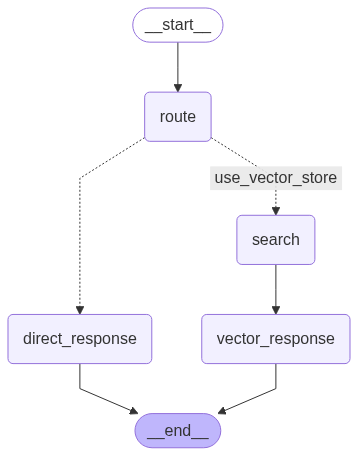

Workflow diagram displayed above.


In [8]:
print("=== RAG Agent Workflow Diagram ===")

try:
    # Generate and display the workflow diagram
    from IPython.display import Image, display
    
    # Get the diagram as PNG bytes
    diagram_png = rag_agent.get_graph().draw_mermaid_png()
    
    # Display the diagram
    display(Image(diagram_png))
    print("Workflow diagram displayed above.")
    
except Exception as e:
    print(f"Could not generate diagram: {e}")
    
    # Fallback: print text representation of the workflow
    print("\nWorkflow Structure (Text):")
    print("1. route (entry point)")
    print("2. decide_knowledge_source() -> LOCAL or GENERAL")
    print("3a. If LOCAL: search -> vector_response -> END")
    print("3b. If GENERAL: direct_response -> END")
    print("\nNodes:")
    print("- route: Initial query processing")
    print("- search: Vector database search")
    print("- vector_response: LLM response with search results")
    print("- direct_response: Direct LLM response")

In [12]:
# First, index a directory 
print("Indexing directory...")
result = index_directory("../unit2.3_langgraph")
print(result) 

Indexing directory...
Starting to process directory: ../unit2.3_langgraph
Found 6 files to process.
Document ../unit2.3_langgraph/researcher_v5.ipynb chunked into 62 pieces
Document ../unit2.3_langgraph/researcher_v3.ipynb chunked into 50 pieces
Document ../unit2.3_langgraph/researcher_v1.ipynb chunked into 5 pieces
Document ../unit2.3_langgraph/research_output_v5_2025_08_08_17_36.md chunked into 2 pieces
Document ../unit2.3_langgraph/researcher_v2.ipynb chunked into 214 pieces
Document ../unit2.3_langgraph/research_output_v5_2025_08_08_17_36_final.md chunked into 2 pieces
Successfully loaded content from 6 readable files.
Successfully created Qdrant vector store using pre-computed embeddings.
Successfully processed directory '../unit2.3_langgraph'. Documents are now indexed with chunked embeddings.


/var/folders/f6/6mkw37fs20q07p9x11q7d7k80000gq/T/ipykernel_78092/625384571.py:53: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-qdrant package and should be used instead. To use it run `pip install -U :class:`~langchain-qdrant` and import as `from :class:`~langchain_qdrant import Qdrant``.
  qdrant = Qdrant(


In [21]:
# all_payloads = []
# while True:
#     points, offset = global_vector_store.client.scroll(
#         collection_name=global_vector_store.collection_name,
#         with_payload=True,
#     )
#     all_payloads.extend([p.payload for p in points])
#     if offset is None:
#         break
#     print([p.payload for p in points])

# all_payloads[:2]
search_results = global_vector_store.similarity_search("Detail analyis on researchers_v1 file", k=4)
search_results[0]

Document(metadata={'_id': '152a7549-e02b-44bb-b951-67cb1787790e', '_collection_name': 'directory_documents'}, page_content='{\n  "cells": [\n    {\n      "cell_type": "markdown",\n      "metadata": {},\n      "source": [\n        "## LLMs"\n      ]\n    },\n    {\n      "cell_type": "code",\n      "execution_count": null,\n      "metadata": {},\n      "outputs": [],\n      "source": [\n        "from llama_index.llms.ollama import Ollama  \\n",\n        "\\n",\n        "chat_model = Ollama(model=\\"qwen2:7b\\", context_window=80000, request_timeout=300)"\n      ]\n    },\n    {\n      "cell_type": "markdown",\n      "metadata": {\n        "id": "dnsDEuS1wHh-"\n      },\n      "source": [\n        "## Researcher: An Agent Workflow\\n",\n        "\\n",\n        "Let\'s create an agent workflow that would: \\n",\n        "defintions  \\n",\n        "     "\n      ]\n    },\n    {\n      "cell_type": "code",\n      "execution_count": null,\n      "metadata": {},\n      "outputs": [],\n     

In [ ]:
# Test 1.1: Local knowledge question (should use vector store)
print("\n--- Test 1: Local Knowledge Question ---")
local_query = "What researcher file version should I use to be able to have an agent with tools?"
local_state = {
    "messages": [HumanMessage(content=local_query)],
    "query": "",
    "search_results": "",
    "needs_local_knowledge": False
}

result = rag_agent.invoke(local_state)
print(f"Query: {local_query}")
print(textwrap.fill(f"Response: {result['messages'][-1]}", width=160))
print(f"Used local knowledge: {result['needs_local_knowledge']}")

print("\n" + "="*50)

In [24]:
# Test 1.2: Local knowledge question (should use vector store)
print("\n--- Test 1: Local Knowledge Question ---")
local_query = "Analysise researcher_v1 file"
local_state = {
    "messages": [HumanMessage(content=local_query)],
    "query": "",
    "search_results": "",
    "needs_local_knowledge": False
}

result = rag_agent.invoke(local_state)
print(f"Query: {local_query}")
print(textwrap.fill(f"Response: {result['messages'][-1]}", width=160))
print(f"Used local knowledge: {result['needs_local_knowledge']}")

print("\n" + "="*50)


--- Test 1: Local Knowledge Question ---
Query: Analysise researcher_v1 file
Response: content='Based on the local documents:\n\nThe researcher_v1 file contains code related to the implementation or usage of an LLM (Language Model).
Specifically, it involves importing a Python module named `llm_index` which provides an interface to interact with AI models for tasks such as text generation.
The code uses Ollama, a language model from the "qwen2:7b" model class, setting its context window size to 80,000 characters and configuring it to handle
requests within a timeout of 300 seconds.\n\nAdditionally, the researcher_v1 file seems to describe various workflows for enhancing or refining research agent
operations. These include:\n\n1. **Planning Sections**: Based on user queries, this part likely involves structuring content into manageable sections.\n2.
**Finding Relevant Web Sources**: This section might cover methods of discovering pertinent internet resources related to each planning se

In [ ]:
# Test 2: General knowledge question (should use direct Ollama)
print("\n--- Test 2: General Knowledge Question ---")
general_query = "Explain history of Prussia briefly."
general_state = {
    "messages": [HumanMessage(content=general_query)],
    "query": "",
    "search_results": "",
    "needs_local_knowledge": False
}

result = rag_agent.invoke(general_state)
print(f"Query: {general_query}")
print(f"Response: {result['messages'][-1]}...")
print(f"Used local knowledge: {result['needs_local_knowledge']}")

print("\n" + "="*50)

In [ ]:

# Test 3: Ambiguous question to test decision making
print("\n--- Test 3: Ambiguous Question ---")
ambiguous_query = "How do I implement a function?"
ambiguous_state = {
    "messages": [HumanMessage(content=ambiguous_query)],
    "query": "",
    "search_results": "",
    "needs_local_knowledge": False
}

result = rag_agent.invoke(ambiguous_state)
print(f"Query: {ambiguous_query}")
print(f"Response: {result['messages'][-1]}...")
print(f"Used local knowledge: {result['needs_local_knowledge']}")

print("\n=== Enhanced RAG System Test Complete ===")